In [1]:
# !pip install pmdarima
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.7 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11953 sha256=a7718759f4af51e96f1acc61ad4dca429c2914b498979022c4bb9f99d3380932
  Stored in directory: /root/.cache/pip/wheels/a8/bb/8f/6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import plotly.express as px

import seaborn as sns
#importing libraries
import pandas as pd 
import numpy as np
#regular expresions
import re
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import preprocessing
# modeling 

import datetime
from sklearn.model_selection import GridSearchCV

now = datetime.datetime.now()
import matplotlib.pyplot as plt 
from glob import glob

In [3]:
# import data
df_train = pd.read_csv('/content/df_train.csv')

Let's explore the columns

In [4]:
df_train.columns

Index(['ARRIVAL DATE', 'RESERVATION DATE', 'ROOMCATEGORY', 'BUCKET', 'BOOK',
       'BOOKG', 'BOOKU', 'BOOKD', 'BOOKT', 'REVENUE', 'ARRIVAL', 'AVGLOS'],
      dtype='object')

The meaning of each column:
- 'ARRIVAL DATE': The date the guest will come to the hotel.
- 'RESERVATION DATE': The date the customer made the booking.

- 'ROOMCATEGORY': Category ID of the room given by the hotel.
- 'BUCKET': Discount ID given by the hotel.
- 'BOOKG': Number of guaranteed bookings made by groups. -    'BOOKU': Number of unguaranteed bookings made by groups.
- 'BOOKD': Number of definite bookings made by individuals.
- 'BOOKT': Number of tentative bookings made by individuals.
- 'BOOK': Total number of bookings.
- 'REVENUE': Revenue made from bookings.
- 'ARRIVAL': Number of arrivals from the bookings.
- 'AVGLOS': Average length of stay (total length of stay of all bookings / total bookings).

Our goal here is to predict the total number of bookings, which means that the 'BOOK' column is our target.

Based on our requirements and the meaning of each column, we must eliminate the feature listed below from the start. :
- 'REVENUE': Revenue made from bookings.

- 'ARRIVAL': Number of arrivals from the bookings.

- 'AVGLOS': Average length of stay (total length of stay of 
all bookings / total bookings).

- 'RESERVATION DATE': The date the guest will come to the hotel.

The first three features are derived directly from the 'BOOK' feature, while the fourth is not included in the predictions file.


In [5]:
df_train.drop(['REVENUE', 'ARRIVAL', 'AVGLOS','RESERVATION DATE'], axis = 1, inplace = True)

# **Exploratory Data Analysis**
**Missing values**

In [6]:
df_train.isnull().sum()

ARRIVAL DATE    0
ROOMCATEGORY    0
BUCKET          0
BOOK            0
BOOKG           0
BOOKU           0
BOOKD           0
BOOKT           0
dtype: int64

In [7]:
df_train['BOOKD'].unique()

array([0])

In [8]:
df_train['BOOKU'].unique()

array([0])

In [9]:
df_train.drop(['BOOKD','BOOKU'], axis= 1, inplace= True)

In [10]:
import datetime
# timestamp = datetime.datetime.strptime(d_BTC['date'][0], "%Y-%m-%d")
df_train['ARRIVAL DATE'] = df_train['ARRIVAL DATE'].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d") )

I removed the features "BOOKD" and "BOOKU" because they only have the value "0" and we must do this to prevent misleading

It is fairly obvious that 'BOOK'='BOOKT'+'BOOKG'.
for that, we must remove 'BOOKT', 'BOOKG', and attempt to predict 'BOOK' directly.




In [11]:
df_train_1 = df_train.drop( ['BOOKT', 'BOOKG'], axis = 1)

In [12]:
df_train_1 = df_train_1.groupby(['ARRIVAL DATE',	'ROOMCATEGORY',	'BUCKET']).sum()

In [13]:
df_train_1.head()

BOOK
ARRIVAL DATE ROOMCATEGORY BUCKET      
2019-01-23   1            1        151
                          3          7
                          4        129
             7            1       4760
                          2       1889

In [14]:
df_train_1 = df_train_1.reset_index()

In [15]:
df_train_1.to_excel('new1.xlsx')

In [16]:
import plotly.subplots as sp
fig = sp.make_subplots(rows=10, cols=1)
i= 1
for  BUCKET in list(df_train_1['BUCKET'].unique()):
  for  ROOMCATEGORY in list(df_train_1['ROOMCATEGORY'].unique()):
    a = df_train_1[df_train_1['BUCKET']==BUCKET]
    b= a[a['ROOMCATEGORY'] ==ROOMCATEGORY ]
    # Create a line plot of the 'BOOK' column over time
    title = 'BOOK for BUCKET =  ' + str(BUCKET) + ' and ROOMCATEGORY =  ' + str(ROOMCATEGORY)

    fig.add_scatter(x=b["ARRIVAL DATE"], y=b["BOOK"], mode="lines",name=title ,
                row=i, col=1)
    i = i+1
    # Show the plot
fig.update_layout(
                  width=1000,
                  height=1000)
fig.show()  

It is quite clear that we have some kind of booking recession between 1/4/2020 and 20/11/2020 in the plots 1/2/4/7/8/9/10. At this point, we have two options:

1- We consider our target 'BOOK' as a time series for each couple ('ROOMCATEGORY', 'BUCKET'), and to ensure consistency, we will only consider 'ARRIVAL DATE' values greater than 20/11/2020 for the said plots.

2- In order to predict 'BOOK' using a regression algorithm, we must remove all rows with a 'ARRIVALE DATE' value between 1/4/2020 and 20/11/2020.

First approach

In this approach, we will create a model for each subdatset (based on the ('ROOMCATEGORY', 'BUCKET') filter pair).

In [17]:
from datetime import date

df_train_1p1 = df_train_1[df_train_1['ARRIVAL DATE'] > datetime.datetime.strptime('2020-11-20', "%Y-%m-%d")]



In order to select the best model, we must first test stationarity.

In [18]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as stattools
def stationary_test(timeseries):
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(label + ' : ' + str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

 
    





In [63]:
for  BUCKET in list(df_train_1p1['BUCKET'].unique()):
  for  ROOMCATEGORY in list(df_train_1p1['ROOMCATEGORY'].unique()):
    a = df_train_1p1[df_train_1p1['BUCKET']==BUCKET]
    b= a[a['ROOMCATEGORY'] ==ROOMCATEGORY ]
    print('********')
    print('stationariry test for BOOK column with  BUCKET =  ' + str(BUCKET) + ' and ROOMCATEGORY =  ' + str(ROOMCATEGORY) )
    stationary_test(b['BOOK'])
    

********
stationariry test for BOOK column with  BUCKET =  1 and ROOMCATEGORY =  1
Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.749725082575074
p-value : 1.0095517502714484e-11
#Lags Used : 7
Number of Observations Used : 709
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
********
stationariry test for BOOK column with  BUCKET =  1 and ROOMCATEGORY =  7
Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.309958281239075
p-value : 5.221481264434904e-06
#Lags Used : 16
Number of Observations Used : 712
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
********
stationariry test for BOOK column with  BUCKET =  2 and ROOMCATEGORY =  1
Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.446853537288778
p-value : 1.5581657311377097e-08
#Lags Used : 4
Number of Observations Used : 379
Strong evidence against the null hypothesis
Reject the null hypothesis
Da

As shown above 'BOOK' column is stationary for all subdataset, subsequintly we will use LSTM model to forcast the new value of our target for each subdataset
let's begin by one subset for ('ROOMCATEGORY', 'BUCKET') = (1, 1)

In [148]:
a = df_train_1p1[df_train_1p1['BUCKET']==1]
b= a[a['ROOMCATEGORY'] ==1 ]

In [151]:
(len(b)/2)

358.5

Epoch 1/10
358/358 [==============================] - 149s 397ms/step - loss: 96652.0547
Epoch 2/10
358/358 [==============================] - 148s 414ms/step - loss: 95451.8438
Epoch 3/10
358/358 [==============================] - 153s 428ms/step - loss: 94480.7812
Epoch 4/10
358/358 [==============================] - 148s 414ms/step - loss: 93585.8125
Epoch 5/10
358/358 [==============================] - 149s 415ms/step - loss: 92763.5625
Epoch 6/10
358/358 [==============================] - 151s 423ms/step - loss: 91985.6016
Epoch 7/10
358/358 [==============================] - 149s 417ms/step - loss: 91243.8125
Epoch 8/10
358/358 [==============================] - 162s 453ms/step - loss: 90546.0625
Epoch 9/10
358/358 [==============================] - 156s 437ms/step - loss: 89859.5156
Epoch 10/10
358/358 [==============================] - 158s 439ms/step - loss: 89187.2812


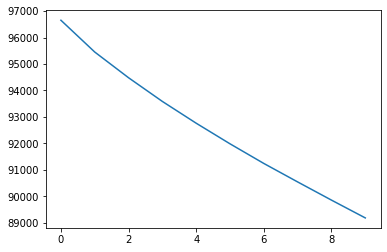

In [152]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import datetime
train = np.array(b['BOOK'])
n_input = 359
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
X,y = generator[0]
model = Sequential()
model.add(LSTM(64, input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=10)
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

We will disregard this approach because the loss function values are extremely high for only one subset, despite the fact that the loss function has been reduced.

We might get better results if we add more epochs, but that takes more time and resources.

# Second approach
To predict 'BOOK' using a regression algorithm, we must remove all rows with 'ARRIVALE DATE' values between 1/4/2020 and 20/11/2020.

In [78]:
h1 = df_train_1[df_train_1['ARRIVAL DATE'] > datetime.datetime.strptime('2020-11-20', "%Y-%m-%d")]
h2 = df_train_1[df_train_1['ARRIVAL DATE'] < datetime.datetime.strptime('2020-4-1', "%Y-%m-%d")]
df_train_1p2 = pd.concat([h1,h2], axis = 0)


Let's look at our targer distribution for each couple ('ROOMCATEGORY', 'BUCKET').

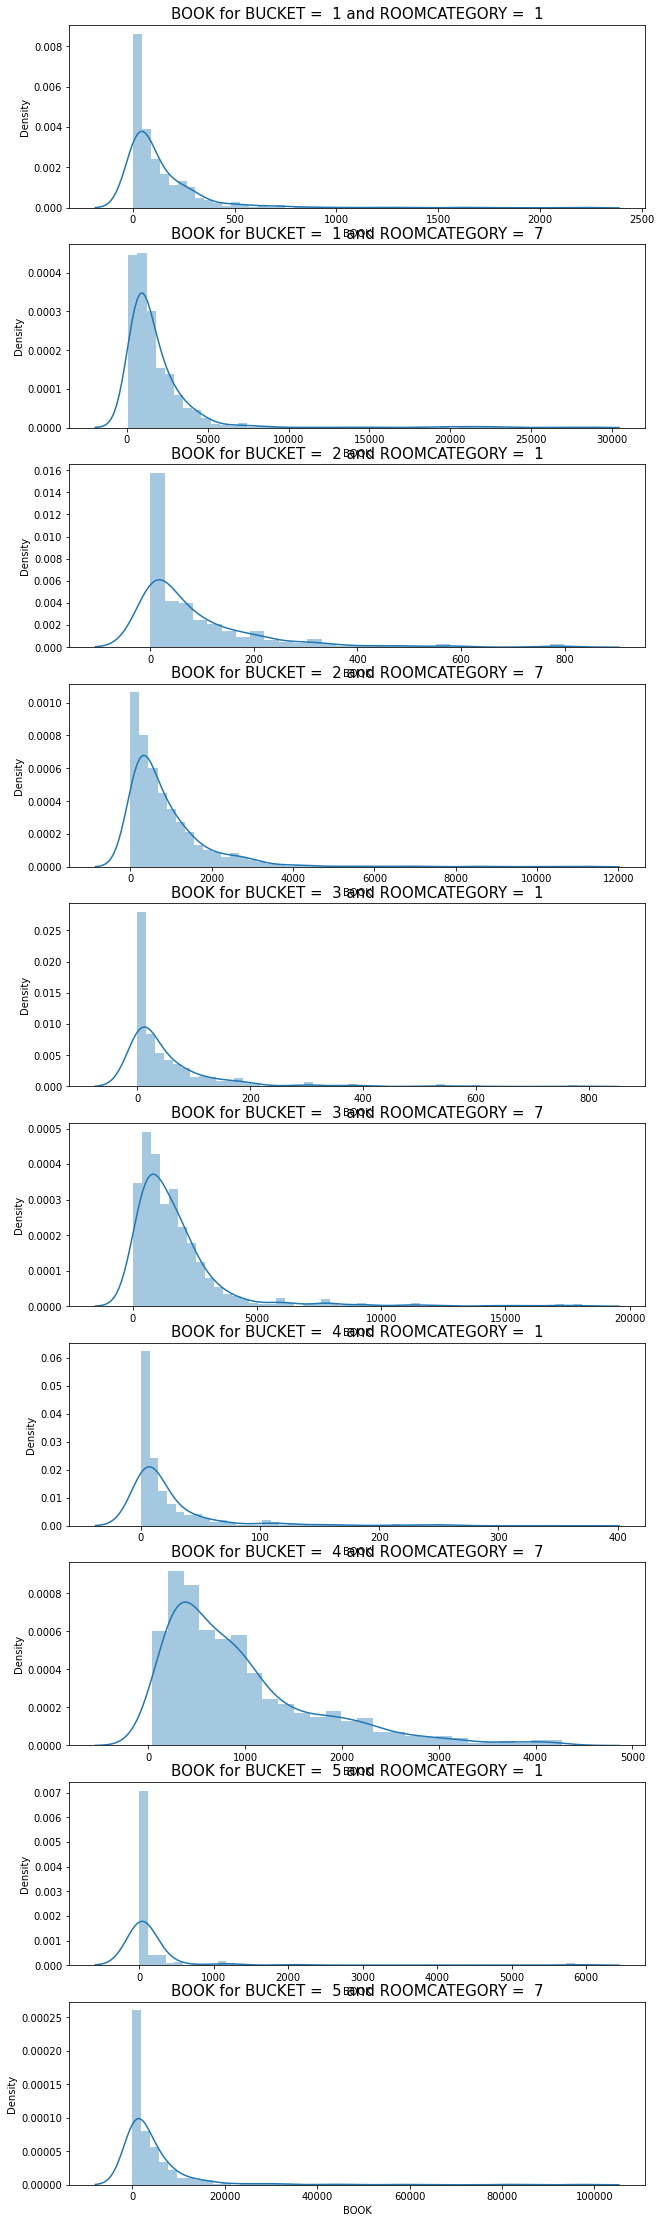

In [79]:
i=1
fig = plt.gcf()
fig.set_size_inches(10, 10)
for  BUCKET in list(df_train_1p2['BUCKET'].unique()):
  for  ROOMCATEGORY in list(df_train_1p2['ROOMCATEGORY'].unique()):
    a = df_train_1p2[df_train_1p2['BUCKET']==BUCKET]
    b= a[a['ROOMCATEGORY'] ==ROOMCATEGORY ]

  
    ax = plt.subplot(10,1, i)
    sns.distplot(b['BOOK'])
    title = 'BOOK for BUCKET =  ' + str(BUCKET) + ' and ROOMCATEGORY =  ' + str(ROOMCATEGORY)

    plt.title(title, fontsize = 15)

    i=i+1 
plt.subplots_adjust(left = 0, right = 0.8, bottom = 0, top = 3, wspace = 0.2, hspace = 0.2)
plt.show()

Let us examine the distribution of our target for the wholl data.

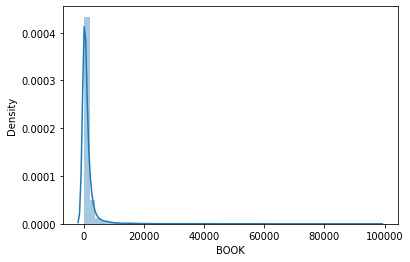

In [80]:
sns.distplot(df_train_1p2['BOOK'])

It is obvious that all distributions have been skiwed, so we will use the log on our target to bring it closer to the normal distribution.

In [81]:
for i in df_train_1p2.index:
  if df_train_1p2['BOOK'][i] == 0 :
    df_train_1p2['BOOK'][i] = 1



In [82]:
df_train_1p2['BOOK'] = np.log( df_train_1p2['BOOK'])

relationship between our target and BUCKET column for each ROOMCATEGORY value

In [83]:

for  ROOMCATEGORY in list(df_train_1p2['ROOMCATEGORY'].unique()):
    a = df_train_1p2[df_train_1p2['ROOMCATEGORY']==ROOMCATEGORY]
    title = 'relationship between BOOK and BUCKET for ROOMCATEGORY =  ' + str(ROOMCATEGORY)
    px.scatter(a,'BUCKET','BOOK',).show()

    

for the wholl data 

In [84]:
px.scatter(df_train_1p2,'BUCKET','BOOK').show()

Although there is no linear or square relationship between BOOK and BUCKET, we can say that our target is distributed equally for each BUCkET value.

let's check outliars for each couple ('ROOMCATEGORY', 'BUCKET')

In [85]:
for  BUCKET in list(df_train_1p2['BUCKET'].unique()):
  for  ROOMCATEGORY in list(df_train_1p2['ROOMCATEGORY'].unique()):
    a = df_train_1p2[df_train_1p2['BUCKET']==BUCKET]
    b= a[a['ROOMCATEGORY'] ==ROOMCATEGORY ]
    title = 'BOOK for BUCKET =  ' + str(BUCKET) + ' and ROOMCATEGORY =  ' + str(ROOMCATEGORY)
    px.box(b['BOOK'], title=title ).show()

There are some outliers for some couples ('ROOMCATEGORY,' 'BUCKET), so we must get rid of them.

In [86]:
def outliers_dtc(l):
  t = 3 #threshomd
  out_indx = []
  
  for i in l.index : 
    z = abs((l[i]-l.mean())/l.std())
    if z>t:
      out_indx.append(i)

  return out_indx

In [87]:
for  BUCKET in list(df_train_1p2['BUCKET'].unique()):
  for  ROOMCATEGORY in list(df_train_1p2['ROOMCATEGORY'].unique()):
    a = df_train_1p2[df_train_1p2['BUCKET']==BUCKET]
    b= a[a['ROOMCATEGORY'] ==ROOMCATEGORY ]
    out_indx = outliers_dtc(b['BOOK'])
    
    df_train_1p2 = df_train_1p2.drop(out_indx, axis = 0)

The 'ARRIVAL DATE' column will be converted from date to duration in seconds, with 2019/1/28 as the reference point.

In [88]:
df_train_1p2_copy = df_train_1p2.copy()

In [89]:
def date_to_float(date):
    timestamp = (date - datetime.datetime(2019,1,28)).total_seconds()
    return timestamp / 86400
df_train_1p2['ARRIVAL DATE'] =  df_train_1p2['ARRIVAL DATE'].map(lambda x: date_to_float(x) )

In [133]:
X = df_train_1p2.drop("BOOK", axis=1)
y = df_train_1p2["BOOK"]


Scaler (we can ignore it)

In [91]:
# from sklearn.preprocessing import StandardScaler
# y = np.array(y).reshape(-1,1)
# scaler = StandardScaler()

# # Fit the StandardScaler to the dataset
# scaler.fit(y)

# # Transform the dataset
# # y = scaler.transform(y)

In [92]:
# y = np.array(y).reshape(-1,1)
# y = scaler.transform(y)

In [93]:
from tpot import TPOTRegressor

tpot_automl = TPOTRegressor(generations=10, population_size=10, 
                            verbosity=2, scoring='r2',   
                            max_time_mins=8, random_state = 666)

In [169]:
tpot_automl.fit(X, y)

Optimization Progress:   0%|          | 0/10 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5237921865992238

Generation 2 - Current best internal CV score: 0.5237921865992238

Generation 3 - Current best internal CV score: 0.5359176431233259

Generation 4 - Current best internal CV score: 0.5359176431233259

Generation 5 - Current best internal CV score: 0.5359176431233259

Generation 6 - Current best internal CV score: 0.5359176431233259

Generation 7 - Current best internal CV score: 0.5399266294847582

Generation 8 - Current best internal CV score: 0.5399266294847582

Generation 9 - Current best internal CV score: 0.5399266294847582

Generation 10 - Current best internal CV score: 0.5399266294847582

Best pipeline: ExtraTreesRegressor(PCA(input_matrix, iterated_power=5, svd_solver=randomized), bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=15, min_samples_split=3, n_estimators=100)


TPOTRegressor(generations=10, max_time_mins=8, population_size=10,
              random_state=666, scoring='r2', verbosity=2)

In [170]:
tpot_automl.export('tpot_best_model.py')

In [36]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
exported_pipeline = make_pipeline(
    PCA(iterated_power=5, svd_solver="randomized"),
    ExtraTreesRegressor(bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=3, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 666)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_train)


In [37]:
from sklearn.metrics import r2_score
r2_score(y_train, results)

0.7688222980409762

In [38]:
r2_score(y_test, exported_pipeline.predict(X_test))

0.6993407596596373

In [39]:
pdf = pd.read_csv('/content/predictions.csv')

In [40]:
pdf['ARRIVAL DATE'] = pdf['ARRIVAL DATE'].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d") )

In [41]:
pdf['ARRIVAL DATE'] =  pdf['ARRIVAL DATE'].map(lambda x: date_to_float(x) )

In [42]:
pred = exported_pipeline.predict(pdf.drop('BOOK', axis=1))

In [43]:
pred = scaler.inverse_transform((np.array(pred)).reshape(-1,1))

In [44]:
pred = np.exp(pred)

In [48]:
pdf['BOOK'] = pred

In [49]:
pdf.to_excel('pdf.xlsx')

In [50]:
pdf['BOOK']

0      0.754610
1      0.754610
2      0.754610
3      0.754610
4      0.754610
         ...   
655    1.737484
656    1.737484
657    1.737484
658    1.737484
659    1.737484
Name: BOOK, Length: 660, dtype: float64

It is clear that our model does not consider the 'ARRIVAL DATE,' but it does consider it as an ID.

In [131]:
df_train_1p2_copy['year'] = 0
df_train_1p2_copy['year'] = [df_train_1p2_copy['ARRIVAL DATE'][i].year for i in df_train_1p2_copy.index  ]
df_train_1p2_copy['month'] = 0
df_train_1p2_copy['month'] = [df_train_1p2_copy['ARRIVAL DATE'][i].month for i in df_train_1p2_copy.index  ]
df_train_1p2_copy['day'] = 0
df_train_1p2_copy['day'] = [df_train_1p2_copy['ARRIVAL DATE'][i].day for i in df_train_1p2_copy.index  ]

In [132]:
X_new = df_train_1p2_copy.drop(['ARRIVAL DATE', 'BOOK'], axis = 1)

In [147]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
exported_pipeline = make_pipeline(
    PCA(iterated_power=5, svd_solver="randomized"),
    ExtraTreesRegressor(bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=6, min_samples_split=3, n_estimators=200)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 666)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_train)
from sklearn.metrics import r2_score
r2_score(y_train, results)


0.7891733713236995

In [136]:
r2_score(y_test, exported_pipeline.predict(X_test))

0.7049187179659225

In [137]:
pdf = pd.read_csv('/content/predictions.csv')

In [138]:
pdf['ARRIVAL DATE'] = pdf['ARRIVAL DATE'].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d") )

In [139]:
pdf['year'] = 0
pdf['year'] = [pdf['ARRIVAL DATE'][i].year for i in pdf.index  ]
pdf['month'] = 0
pdf['month'] = [pdf['ARRIVAL DATE'][i].month for i in pdf.index  ]
pdf['day'] = 0
pdf['day'] = [pdf['ARRIVAL DATE'][i].day for i in pdf.index  ]

In [141]:
pred = exported_pipeline.predict(pdf.drop(['BOOK','ARRIVAL DATE'], axis = 1))

In [143]:
pred = np.exp(pred)

In [154]:
pdf['BOOK'] = np.round(pred)

In [155]:
pdf.to_csv('pred_final.csv')

## More options

We can examine the trend and the sesonality in our data and build an RNN (recurrent neuron network) with more layers and nodes using LSTM.